**Goal of the Code:** Create a figure to show how temperature conditions change under SAI and how that influences permafrost fraction in the Arctic. The first plot shows under what temperature conditions permafrost was observed in the Arctic between 2000-2016. The second plot diplays the temperature conditions in the Arctic of RCP8.5 when the scenario reaches 2°C global warming. The final two plots show the difference in temperature conditions from when SAI reaches +2°C and when RCP8.5 reaches +2°C. Plotted are the conditions for SAI, minus the conditions under RCP8.5.


In [1]:
import numpy as np
import iris
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm
import matplotlib
import matplotlib.ticker as ticker 
from matplotlib import cm
from matplotlib.colors import ListedColormap

Define a function to calculate the frequency grid of 2.0x3.0 based on T$_{mean}$ and T$_{Xx}$. -30 and -55 is so that the grid starts from -30 and -55 and not from 0.

In [2]:
def grid(T_mean, TNn):
    x = int(round(((T_mean) - (-30 + 2.0 / 2)) / 2.0)) ## 212.5 instead of 210 so that the bins actually go from 210 - 215 an not from 207.2 - 212.5
    y = int(round(((TNn) - (-55 + 3.0 / 2)) / 3.0))
    return(x,y)

The first figure will be the current conditions of permafrost fraction in the Arctic. That dataset has already been created and stored in a txt. It needs to be converted to a grid of 20x20 so it can later be plotted accordingly. 

In [3]:
with open(r"20x20_perma.txt") as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
    
float_list = []

for i in range(0, len(lines)):
    float_list.append(float(lines[i]))
    
Perm_array = np.zeros((20,20)) 
zaehler = -1

for x in range(0, 20):
    for y in range(0, 20):
        zaehler += 1
        Perm_array[x][y] = float_list[zaehler] * 100

There are some filler values in the dataset that need to be assigned NaN so they do not get plotted. A list for both the x- and the y-axis is created.

In [4]:
Perm_array = np.where(Perm_array == 0, np.nan, Perm_array)
Perm_array = np.where(Perm_array == -9999*100, np.nan, Perm_array)

Perm_x_axes = np.arange(-30,10 + 1.0, 2.0).tolist()
Perm_y_axes = np.arange(-55,5 + 1.5, 3.0).tolist() 

The second figure displays T$_{mean}$, T$_{Nn}$ frequencies of RCP8.5 where the scenario reaches 2°C global warming north of 65°N. First, the datasets are loaded and a landmask is applied.

In [5]:
path = r""

landmask = iris.load(path + "TSA_01_sel_var_CCT.all.nc")[0][:,82:,:]

T_mean_RCP = iris.load(path + "TS_sel_var_RCP85_cam.all.nc")[0][(34)*12:(34 + 21)*12,82:,:]
T_mean_RCP.data.mask = landmask.data.mask
T_mean_RCP = T_mean_RCP.data

TNn_RCP = iris.load(path +  "TREFMNAV_sel_var_RCP85.all.nc")[0][(34)*12:(34 + 21)*12,82:,:].data

Now, the grid array is calculated. This is achieved by looping over all grid cells, excluding those that are over ocean. For each time step, the yearly mean of monthly T$_{mean}$ and the mean od DJF T$_{min}$ is calculated. The grid function is used to fill the values in the array.. The function gives two integer values that indicate, where in the array a +1 has to be added.

In [6]:
array_RCP = np.zeros((100,100)) ## empty array that now gets filled with values

time = 0
else_sum = 0

T_mean = []
T_min = []

for lat in range(0,14):
        for lon in range(0,144):
                if landmask.data.mask[0,lat,lon] == False:        
                    time = 0    
                    while time in range(0, 21*12):
                        T_mean = np.mean(T_mean_RCP[time:time+12, lat, lon]) - 273.15
                        if time == 0:
                            T_min = np.mean(TNn_RCP[time:time+2, lat, lon]) - 273.15 ## For first year, no December value is present as it would have to be of year -1
                        else:
                            T_min = np.mean(TNn_RCP[time-1:time+2, lat, lon]) - 273.15
                           
                        x, y = grid(T_mean, T_min)
                        if x >= 0:
                            array_RCP[y][x] = array_RCP[y][x] + 1   
                        else:
                            else_sum += 1
                        time = time + 12

The sum of the total array is calculated and else_sum is added to calculate the divider, to get the frequencies instead of absolute numbers. The array is multiplied with 100 to get percentage values. 0 values are replaced with NaN values. A grid cell outside the area that will be plotted is used to control the colour bar. The x- and y-axis lists are created. Here, they go from -55 to 246.5 and .30 to 171 to account for the 100x100 grid instead of the 28x28 grid. Everything above 10 and 5°C, respectively, will not be plotted later, this is just for coding purposes.

In [7]:
sum_array = sum(map(sum, array_RCP)) + else_sum
array_RCP = array_RCP * 100 / sum_array
plot_array_RCP = np.where(array_RCP == 0, np.nan, array_RCP)
plot_array_RCP[28][28] = 0.045

RCP_y_axes = np.arange(-55,245+1.5, 3.0).tolist()
RCP_x_axes = np.arange(-30,170+1.0, 2.0).tolist()    

Finally, the figure displaying the difference between SAI and RCP8.5 where the scenarios reach 2°C global mean temperature increase is created. First, the datasets for SAI are loaded. 

In [8]:
path = r""

T_mean_SAI_01 = iris.load(path + "TS_01_sel_var_SAI_cam.all.nc")[0][(36)*12:(36 + 21+1)*12,82:,:]
T_mean_SAI_02 = iris.load(path + "TS_02_sel_var_SAI_cam.all.nc")[0][(37)*12:(37 + 21+1)*12,82:,:]
T_mean_SAI_03 = iris.load(path + "TS_03_sel_var_SAI_cam.all.nc")[0][(37)*12:(37 + 21+1)*12,82:,:]

T_mean_SAI_01.data.mask = landmask.data.mask
T_mean_SAI_02.data.mask = landmask.data.mask
T_mean_SAI_03.data.mask = landmask.data.mask

T_mean_SAI_01 = T_mean_SAI_01.data
T_mean_SAI_02 = T_mean_SAI_02.data
T_mean_SAI_03 = T_mean_SAI_03.data

TNn_SAI_01 = iris.load(path + "TREFMNAV_01_sel_var_SAI.all.nc")[0][(36)*12:(36 + 21+1)*12,82:,:].data
TNn_SAI_02 = iris.load(path + "TREFMNAV_02_sel_var_SAI.all.nc")[0][(37)*12:(37 + 21+1)*12,82:,:].data
TNn_SAI_03 = iris.load(path + "TREFMNAV_03_sel_var_SAI.all.nc")[0][(37)*12:(37 + 21+1)*12,82:,:].data

Again, the same procedure as above where the temperature frequencies of SAI are calculated. The mean of the three ensembles is calculated.

In [9]:
array_RFG = np.zeros((100,100))
time = 0
else_sum = 0

for lat in range(0,14):
        for lon in range(0,144):
            if landmask.data.mask[0,lat,lon] == False:   
                time = 0
                while time in range(0, 21*12):
                    T_mean_01 = np.mean(T_mean_SAI_01[time:time+12, lat, lon]) - 273.15
                    T_mean_02 = np.mean(T_mean_SAI_02[time:time+12, lat, lon]) - 273.15
                    T_mean_03 = np.mean(T_mean_SAI_03[time:time+12, lat, lon]) - 273.15
                    if time == 0:
                        T_min_01 = np.mean(TNn_SAI_01[time:time+2, lat, lon]) - 273.15
                        T_min_02 = np.mean(TNn_SAI_02[time:time+2, lat, lon]) - 273.15
                        T_min_03 = np.mean(TNn_SAI_03[time:time+2, lat, lon]) - 273.15
                    else:
                        T_min_01 = np.mean(TNn_SAI_01[time-1:time+2, lat, lon]) - 273.15
                        T_min_02 = np.mean(TNn_SAI_02[time-1:time+2, lat, lon]) - 273.15
                        T_min_03 = np.mean(TNn_SAI_03[time-1:time+2, lat, lon]) - 273.15
  
                    x, y = grid((T_mean_01+T_mean_02+T_mean_03)/3, (T_min_01+T_min_02+T_min_03)/3)
                    if x >= 0:
                        array_RFG[y][x] = array_RFG[y][x] + 1
                    else:
                        else_sum += 1
                        
                    time = time + 12

The frequency array in % is calculated. To calculate the difference to when RCP8.5 reaches +2°, the grid array calculated for RCP8.5 above is subtracted from the SAI array. Grids outside the area that will be plotted later are used to control the colour bar. The x- and y-axis lists are created.

In [10]:
sum_array = sum(map(sum, array_RFG)) + else_sum

array_RFG = array_RFG * 100 / sum_array

subt_array = np.subtract(array_RFG, array_RCP)

subt_array = np.where(subt_array == 0, np.nan, subt_array)

subt_array[28][28] = 2.4
subt_array[28][27] = -1.6

RFG_y_axes = np.arange(-55,245+1.5, 3.0).tolist()
RFG_x_axes = np.arange(-30,170+1.0, 2.0).tolist()  

Plotting of the grid arrays.

C:\Users\rhonda\AppData\Local\Temp/ipykernel_3432/3352550253.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax1.plot([-55,10], [-55,10], "g--", color = "black")
C:\Users\rhonda\AppData\Local\Temp/ipykernel_3432/3352550253.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax2.plot([-55,10], [-55,10], "g--", color = "black")
C:\Users\rhonda\AppData\Local\Temp/ipykernel_3432/3352550253.py:86: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax3.plot([-55,10], [-55,10], "g--", color = "black")


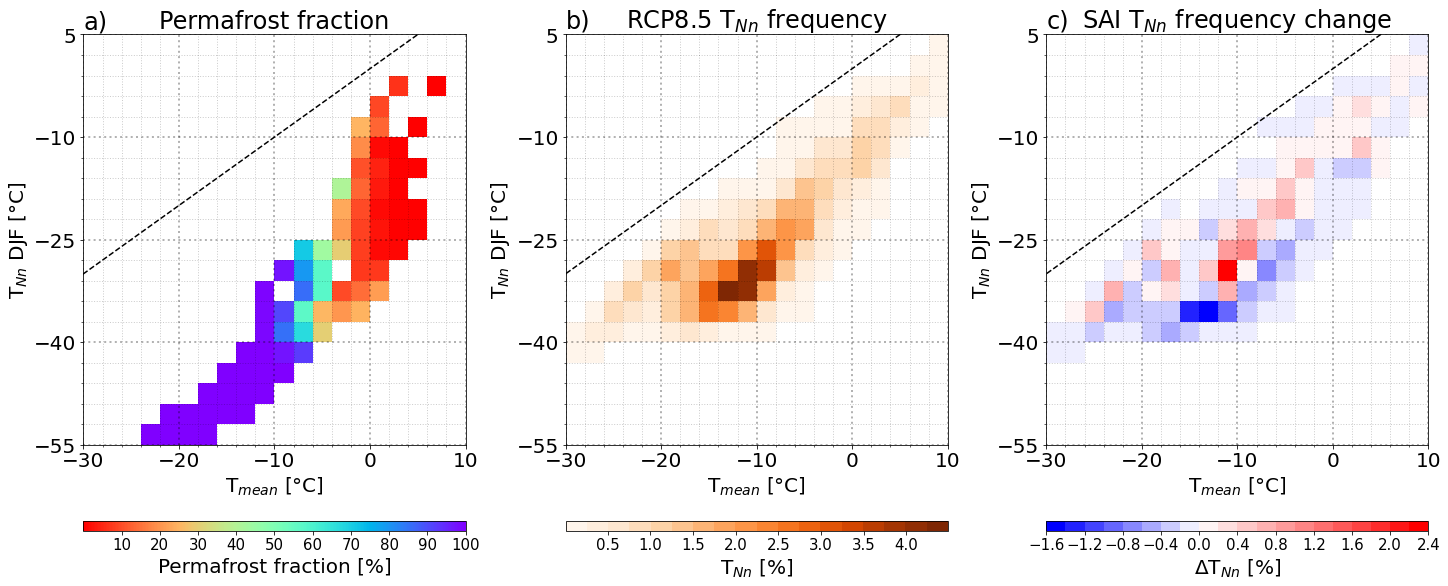

In [11]:
matplotlib.rcParams.update({'font.size': 20})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  sharex = True, figsize = (20,8), constrained_layout = True)

## Plot a - permafrost ##

cmap2 = mpl_cm.get_cmap('rainbow_r')
im1 = ax1.pcolormesh(Perm_x_axes, Perm_y_axes, Perm_array, cmap = cmap2)
ax1.plot([-55,10], [-55,10], "g--", color = "black")
ax1.set_xlim(-30,10)
ax1.set_ylim(-55,5)
ax1.set_xlabel("T$_{mean}$ [°C]")
ax1.set_ylabel("T$_{Nn}$ DJF [°C]")

ax1.set_title("Permafrost fraction")
ax1.set_title("a)", loc = "left")

major_ticks_top_y=np.linspace(-55,5,5)
major_ticks_top_x=np.linspace(-30,10,5)
minor_ticks_top_y=np.linspace(-55,5,21)
minor_ticks_top_x=np.linspace(-30,10,21)

ax1.set_xticks(major_ticks_top_x)
ax1.set_yticks(major_ticks_top_y)
ax1.set_xticks(minor_ticks_top_x,minor=True)
ax1.set_yticks(minor_ticks_top_y,minor=True)

ax1.grid(which="major",color="black", alpha=.3, linewidth=2, linestyle=":")
ax1.grid(which="minor",color="black", alpha=.2, linewidth=1, linestyle=":")

cb = plt.colorbar(im1, ax = ax1, orientation="horizontal", pad = 0.05, aspect=40)  
cb.set_label("Permafrost fraction [%]")
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
cb.ax.tick_params(labelsize=15) 

## Plot b - RCP8.5 first 21 years ##

cmap3 = mpl_cm.get_cmap('Oranges', 18) #bwr

im2 = ax2.pcolormesh(RCP_x_axes, RCP_y_axes, plot_array_RCP, cmap = cmap3)
ax2.plot([-55,10], [-55,10], "g--", color = "black")
ax2.set_xlim(-30,10)
ax2.set_ylim(-55,5)
ax2.set_xlabel("T$_{mean}$ [°C]")
ax2.set_ylabel("T$_{Nn}$ DJF [°C]")

ax2.set_title("RCP8.5 T$_{Nn}$ frequency")
ax2.set_title("b)", loc = "left")

major_ticks_top_y=np.linspace(-55,5,5)
major_ticks_top_x=np.linspace(-30,10,5)
minor_ticks_top_y=np.linspace(-55,5,21)
minor_ticks_top_x=np.linspace(-30,10,21)

ax2.set_xticks(major_ticks_top_x)
ax2.set_yticks(major_ticks_top_y)
ax2.set_xticks(minor_ticks_top_x,minor=True)
ax2.set_yticks(minor_ticks_top_y,minor=True)

ax2.grid(which="major",color="black", alpha=.3, linewidth=2, linestyle=":")
ax2.grid(which="minor",color="black", alpha=.2, linewidth=1, linestyle=":")

cb = plt.colorbar(im2, ax = ax2, orientation="horizontal", pad = 0.05, aspect=40)  
cb.set_label("T$_{Nn}$ [%]")
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
cb.ax.tick_params(labelsize=15) 

## Plot c - SAI when +2°C ##

viridis_30 = cm.get_cmap('bwr', 16) ## Create a custom colourmap
viridis_20 = cm.get_cmap("bwr",20)
viridis_10 = cm.get_cmap("bwr", 24)
newcolors_30 = viridis_30(np.linspace(0, 1, 16))
newcolors_20 = viridis_20(np.linspace(0, 1, 20))
newcolors_10 = viridis_10(np.linspace(0, 1, 24))
newcolors_20[:8, :] = (newcolors_30[:8, :])
newcolors_20[8:, :] = (newcolors_10[12:,:])
newcmp = ListedColormap(newcolors_20)

cmap = newcmp

im3 = ax3.pcolormesh(RFG_x_axes, RFG_y_axes, subt_array, cmap = cmap)
ax3.plot([-55,10], [-55,10], "g--", color = "black")
ax3.set_xlim(-30,10)
ax3.set_ylim(-55,5)
ax3.set_xlabel("T$_{mean}$ [°C]")
ax3.set_ylabel("T$_{Nn}$ DJF [°C]")

ax3.set_title("SAI T$_{Nn}$ frequency change")
ax3.set_title("c)", loc = "left")

major_ticks_top_y=np.linspace(-55,5,5)
major_ticks_top_x=np.linspace(-30,10,5)
minor_ticks_top_y=np.linspace(-55,5,21)
minor_ticks_top_x=np.linspace(-30,10,21)

ax3.set_xticks(major_ticks_top_x)
ax3.set_yticks(major_ticks_top_y)
ax3.set_xticks(minor_ticks_top_x,minor=True)
ax3.set_yticks(minor_ticks_top_y,minor=True)

ax3.grid(which="major",color="black", alpha=.3, linewidth=2, linestyle=":")
ax3.grid(which="minor",color="black", alpha=.2, linewidth=1, linestyle=":")

cb = plt.colorbar(im3, ax = ax3, orientation="horizontal", pad = 0.05, aspect=40)  
cb.set_label("$\Delta$T$_{Nn}$ [%]")
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.ax.tick_params(labelsize=15) 
cb.update_ticks()
